Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - accuracy: 0.1954 - loss: 2.2042 - val_accuracy: 0.3854 - val_loss: 1.6649
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3838 - loss: 1.6769 - val_accuracy: 0.4206 - val_loss: 1.5836
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4245 - loss: 1.5784 - val_accuracy: 0.4496 - val_loss: 1.5137
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4468 - loss: 1.5104 - val_accuracy: 0.4749 - val_loss: 1.4422
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4663 - loss: 1.4559 - val_accuracy: 0.4873 - val_loss: 1.4142


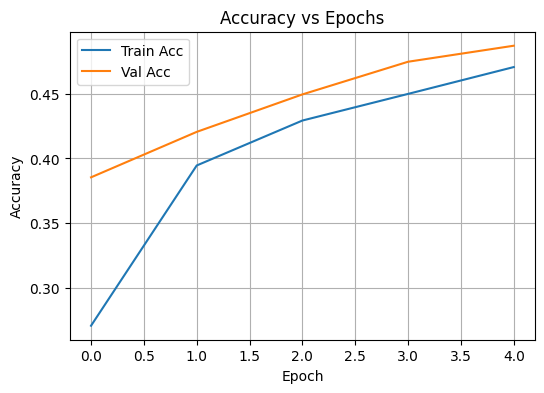

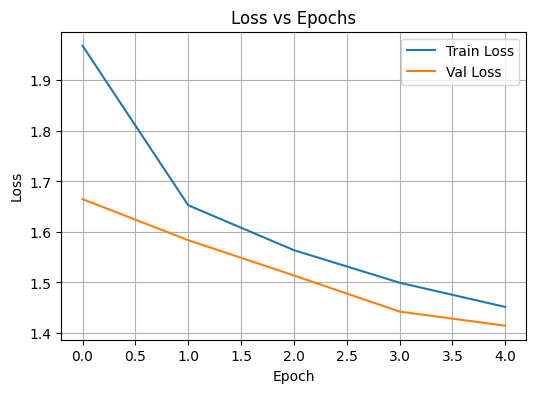


Test Accuracy: 0.4969

Classification Report:

              precision    recall  f1-score   support

    airplane       0.53      0.57      0.55      1000
  automobile       0.58      0.64      0.61      1000
        bird       0.41      0.36      0.38      1000
         cat       0.36      0.34      0.35      1000
        deer       0.51      0.26      0.35      1000
         dog       0.46      0.42      0.44      1000
        frog       0.48      0.56      0.52      1000
       horse       0.50      0.62      0.55      1000
        ship       0.55      0.72      0.62      1000
       truck       0.57      0.47      0.52      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



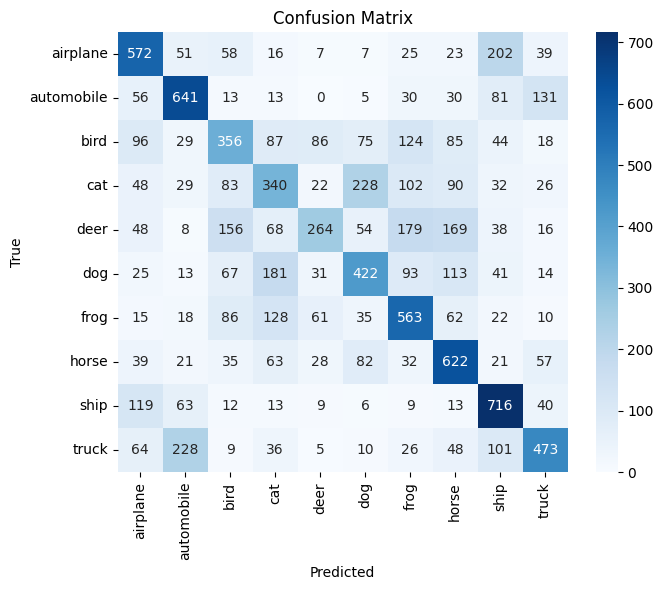

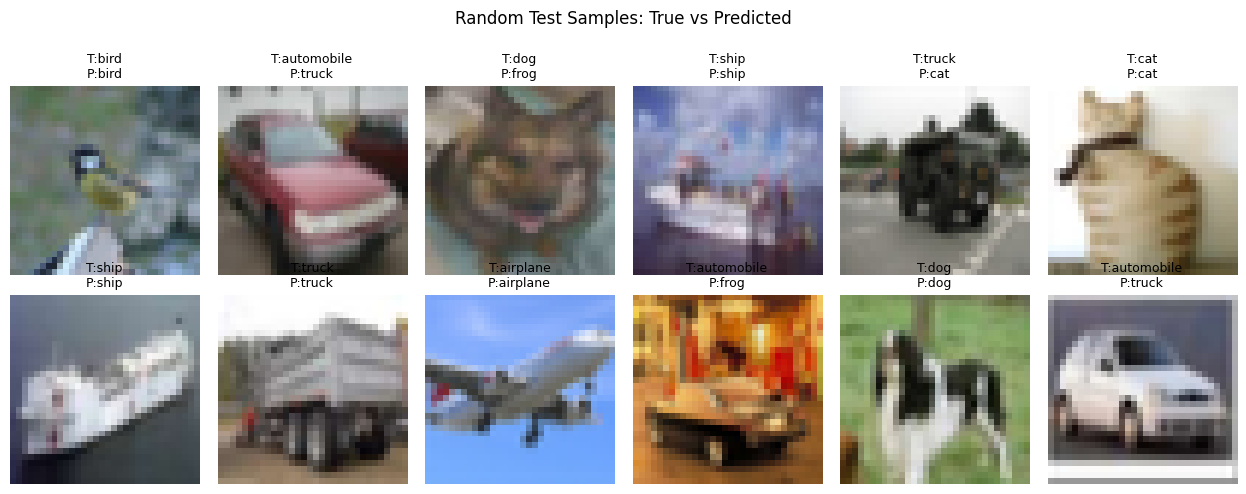

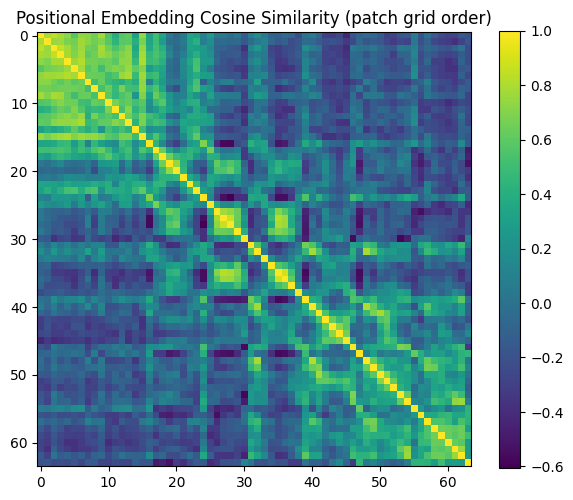

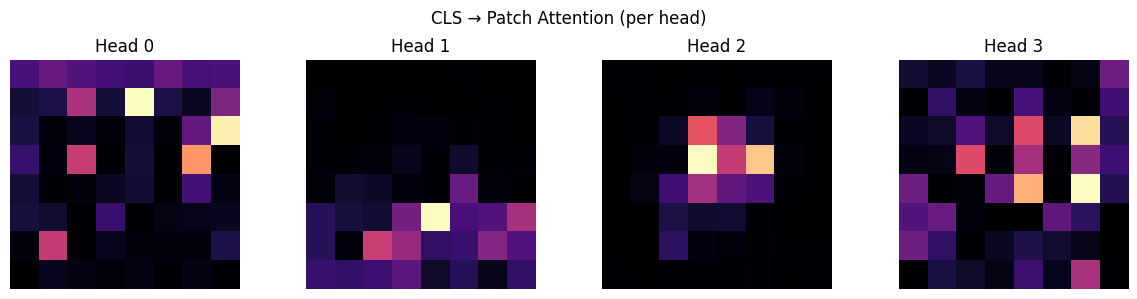

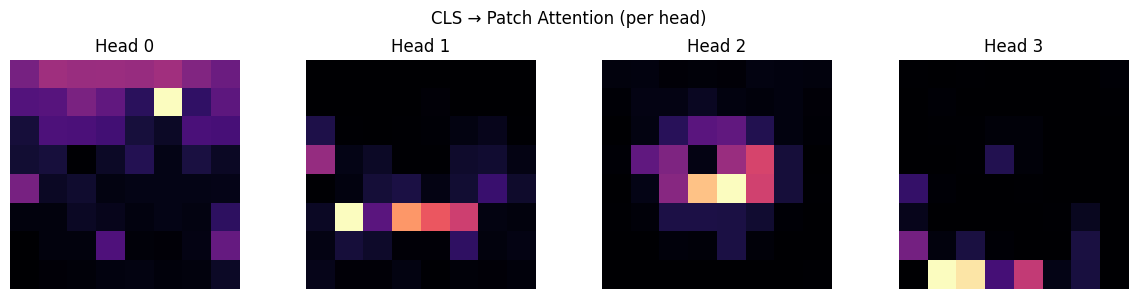

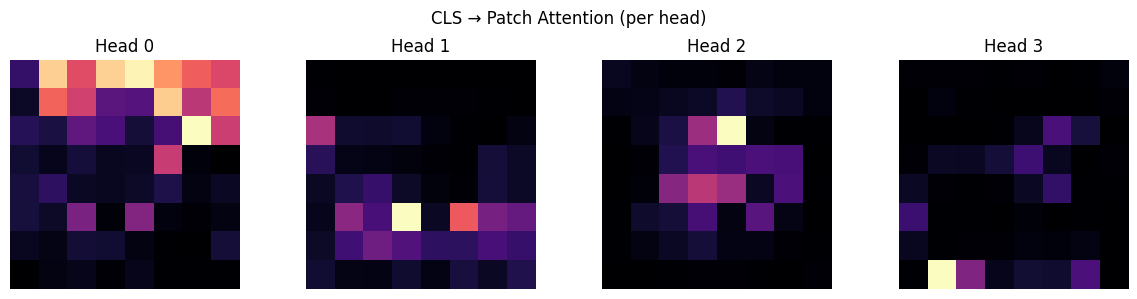

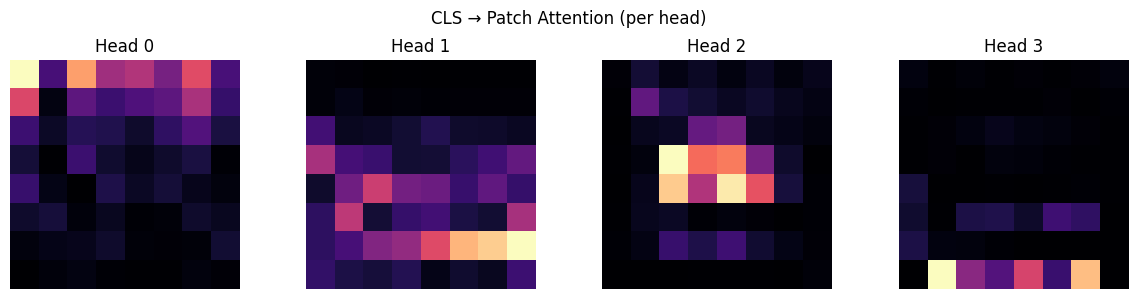

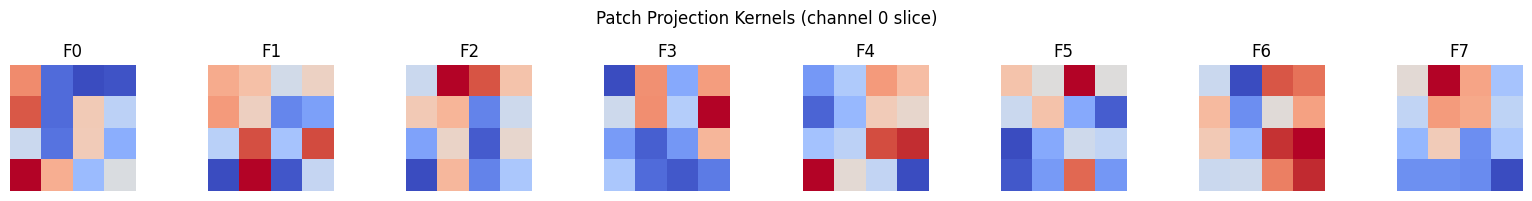


Done. This minimal ViT (1 block) illustrates core design choices from the original paper with pedagogical training and rich visualizations.


In [6]:
# ================================================================
# Vision Transformer (ViT) — One Encoder Block, 5 Epochs, Rich Visualizations
# Paper: "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"
#        (Dosovitskiy et al., ICLR 2021)
#
# Core ideas reproduced:
# - Patch embedding
# - Learnable class token
# - Learnable 1D positional embeddings
# - Pre-norm Transformer encoder block (MHSA + MLP) with residual connections
# - GELU-activated MLP
#
# Dataset: CIFAR-10 (32x32) — patch size = 4 → 8x8 = 64 tokens
# Training: 5 epochs for pedagogical speed
#
# Visualizations:
# - Training curves
# - Confusion matrix
# - Sample predictions
# - Positional embedding similarity
# - Class-token attention maps (per head)
# - Projection-kernel glimpses
#
# Author: Your Name (Machine Learning Engineer)
# ================================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Reproducibility & Config
# -----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASS_NAMES = [
    'airplane','automobile','bird','cat','deer',
    'dog','frog','horse','ship','truck'
]
IMG_SIZE = 32
PATCH = 4                # 4x4 patches → 8x8 = 64 tokens
NUM_PATCHES = (IMG_SIZE // PATCH) ** 2
D_MODEL = 128
NUM_HEADS = 4            # D_MODEL % NUM_HEADS == 0
MLP_DIM = 256
DROPOUT = 0.1
EPOCHS = 5
BATCH_SIZE = 128

# -----------------------------
# Data
# -----------------------------
def load_data():
    """Load CIFAR-10 dataset, normalize, and one-hot encode labels."""
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test  = x_test.astype('float32') / 255.0
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat  = to_categorical(y_test, 10)
    return (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat)

# -----------------------------
# ViT Components
# -----------------------------
class PatchEmbed(layers.Layer):
    """Linear projection of (P x P x C) patches to D via Conv2D with stride P."""
    def __init__(self, dim=D_MODEL, patch=PATCH, name='patch_embed'):
        super().__init__(name=name)
        self.proj = layers.Conv2D(
            dim, kernel_size=patch, strides=patch, padding='valid', use_bias=True
        )
        self.flatten = layers.Reshape((-1, dim))

    def call(self, x):
        x = self.proj(x)     # (B, H/P, W/P, D)
        return self.flatten(x)  # (B, N, D)


class AddClassToken(layers.Layer):
    """Add a trainable [CLS] token to the sequence."""
    def __init__(self, dim=D_MODEL, name='add_cls'):
        super().__init__(name=name)
        self.cls = self.add_weight(
            shape=(1, 1, dim),
            initializer='zeros',
            trainable=True,
            name='cls'
        )

    def call(self, x):
        B = tf.shape(x)[0]
        cls = tf.tile(self.cls, [B, 1, 1])
        return tf.concat([cls, x], axis=1)  # (B, 1+N, D)


class AddPositionalEmbedding(layers.Layer):
    """Add learnable positional embeddings."""
    def __init__(self, seq_len, dim=D_MODEL, name='pos_emb'):
        super().__init__(name=name)
        self.pos = self.add_weight(
            name='pos',
            shape=(1, seq_len, dim),
            initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
            trainable=True
        )

    def call(self, x):
        return x + self.pos  # (B, L, D)


class MultiHeadSelfAttention(layers.Layer):
    """Multi-head self-attention with stored attention scores for visualization."""
    def __init__(self, num_heads=NUM_HEADS, key_dim=None, dropout=DROPOUT, name='mhsa'):
        super().__init__(name=name)
        if key_dim is None:
            key_dim = D_MODEL // num_heads
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, dropout=dropout
        )
        self.last_scores = None

    def call(self, x, training=False):
        out, attn = self.mha(x, x, return_attention_scores=True, training=training)
        self.last_scores = attn  # (B, heads, L_q, L_k)
        return out


class EncoderBlock(layers.Layer):
    """Transformer encoder block (pre-norm)."""
    def __init__(self, dim=D_MODEL, num_heads=NUM_HEADS, mlp_dim=MLP_DIM, dropout=DROPOUT, name='enc_block'):
        super().__init__(name=name)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn  = MultiHeadSelfAttention(num_heads=num_heads, key_dim=dim//num_heads, dropout=dropout)
        self.drop1 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp   = tf.keras.Sequential([
            layers.Dense(mlp_dim),
            layers.Activation(tf.nn.gelu),
            layers.Dropout(dropout),
            layers.Dense(dim),
        ])
        self.drop2 = layers.Dropout(dropout)

    def call(self, x, training=False):
        # Pre-norm + MHSA
        h = self.norm1(x)
        h = self.attn(h, training=training)
        x = x + self.drop1(h, training=training)
        # MLP
        h2 = self.norm2(x)
        h2 = self.mlp(h2, training=training)
        x = x + self.drop2(h2, training=training)
        return x


class ViTOneBlock(tf.keras.Model):
    """Minimal ViT with a single encoder block."""
    def __init__(self, num_classes=10, img_size=IMG_SIZE, patch=PATCH,
                 dim=D_MODEL, heads=NUM_HEADS, mlp_dim=MLP_DIM, dropout=DROPOUT):
        super().__init__(name='vit_one_block')
        self.patch = PatchEmbed(dim=dim, patch=patch)
        self.add_cls = AddClassToken(dim=dim)
        self.pos    = AddPositionalEmbedding(seq_len=1 + (img_size//patch)**2, dim=dim)
        self.enc    = EncoderBlock(dim=dim, num_heads=heads, mlp_dim=mlp_dim, dropout=dropout)
        self.norm   = layers.LayerNormalization(epsilon=1e-6)
        self.head   = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x = self.patch(x)
        x = self.add_cls(x)
        x = self.pos(x)
        x = self.enc(x, training=training)
        x = self.norm(x)
        cls = x[:, 0]  # CLS token
        return self.head(cls)

    @property
    def attention_scores(self):
        return self.enc.attn.last_scores

    @property
    def pos_embedding_matrix(self):
        return self.pos.pos

    @property
    def patch_projection_kernel(self):
        return self.patch.proj.get_weights()[0]

# ================================================================
# Training, Evaluation, and Visualization Utilities
# ================================================================
def plot_history(history):
    """Plot training & validation accuracy/loss curves."""
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()


def plot_confusion(y_true, y_pred, class_names):
    """Plot confusion matrix as a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout(); plt.show()


def show_sample_predictions(x, y_true, y_pred, class_names, n=12):
    """Show random test images with true and predicted labels."""
    idxs = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2.1*cols, 2.4*rows))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(x[idx])
        t = class_names[int(y_true[idx])]
        p = class_names[int(y_pred[idx])]
        ax.set_title(f"T:{t}\nP:{p}", fontsize=9)
        ax.axis('off')
    plt.suptitle('Random Test Samples: True vs Predicted', y=1.02)
    plt.tight_layout(); plt.show()

# ================================================================
# ViT-Specific Visualizations
# ================================================================
def visualize_positional_similarity(model):
    """Cosine similarity matrix of positional embeddings (excluding CLS token)."""
    P = model.pos_embedding_matrix.numpy()[0]   # (L, D)
    P_no_cls = P[1:]                             # (N, D)
    P_norm = P_no_cls / (np.linalg.norm(P_no_cls, axis=1, keepdims=True) + 1e-8)
    sim = np.matmul(P_norm, P_norm.T)           # (N, N)

    s = int(np.sqrt(sim.shape[0]))              # grid side length
    plt.figure(figsize=(6,5))
    plt.imshow(sim, cmap='viridis')
    plt.title('Positional Embedding Cosine Similarity (patch grid order)')
    plt.colorbar(); plt.tight_layout(); plt.show()


def visualize_cls_attention(model, images):
    """Per-head attention from CLS token to patch tokens for sample images."""
    # Use forward pass instead of predict() to ensure scores are stored
    _ = model(images, training=False)
    att = model.attention_scores  # (B, H, L, L)
    if att is None:
        print('Attention scores not available.')
        return

    B, H, L, _ = att.shape
    N = L - 1
    s = int(np.sqrt(N))  # patch grid side length
    nshow = min(4, B)

    for i in range(nshow):
        heads = att[i].numpy()  # (H, L, L)
        cls_to_patches = heads[:, 0, 1:]  # (H, N)
        cols = H
        plt.figure(figsize=(3*cols, 3))
        for h in range(H):
            ax = plt.subplot(1, cols, h+1)
            m = cls_to_patches[h].reshape(s, s)
            ax.imshow(m, cmap='magma')
            ax.set_title(f'Head {h}')
            ax.axis('off')
        plt.suptitle('CLS → Patch Attention (per head)')
        plt.tight_layout(); plt.show()


def visualize_projection_kernels(model, max_filters=8):
    """Visualize patch projection filters (channel 0 slice)."""
    W = model.patch_projection_kernel  # (P, P, C, D)
    _, _, _, D = W.shape
    show = min(max_filters, D)

    plt.figure(figsize=(2*show, 2))
    for i in range(show):
        ax = plt.subplot(1, show, i+1)
        k2d = W[:, :, 0, i]   # slice first input channel
        ax.imshow(k2d, cmap='coolwarm')
        ax.axis('off'); ax.set_title(f'F{i}')
    plt.suptitle('Patch Projection Kernels (channel 0 slice)')
    plt.tight_layout(); plt.show()

# ================================================================
# End-to-End Run (5 Epochs)
# ================================================================
if __name__ == '__main__':
    # Load CIFAR-10
    (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat) = load_data()

    # Instantiate model
    model = ViTOneBlock(
        num_classes=10, img_size=IMG_SIZE, patch=PATCH,
        dim=D_MODEL, heads=NUM_HEADS, mlp_dim=MLP_DIM, dropout=DROPOUT
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
        x_train, y_train_cat,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    # Plot training history
    plot_history(history)

    # Evaluate
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    # Predictions
    y_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = y_test.flatten()

    # Classification report & confusion matrix
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    plot_confusion(y_true, y_pred, CLASS_NAMES)
    show_sample_predictions(x_test, y_true, y_pred, CLASS_NAMES, n=12)

    # ViT-specific visualizations
    visualize_positional_similarity(model)
    visualize_cls_attention(model, x_test[:8])
    visualize_projection_kernels(model, max_filters=8)

    print("\nDone. This minimal ViT (1 block) illustrates core design choices "
          "from the original paper with pedagogical training and rich visualizations.")
